In [1]:
!nvidia-smi

Mon Apr 23 21:04:56 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 390.48                 Driver Version: 390.48                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 00000000:26:00.0  On |                  N/A |
|  0%   49C    P8    13W / 200W |    650MiB /  8118MiB |     15%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
# importing data science libraries
import pandas as pd

fraud_dataset = pd.read_csv('../data/nonames.csv')
print("There are ", len(fraud_dataset), " samples")
print(fraud_dataset.shape)
print(fraud_dataset.head(10))
print(fraud_dataset.describe())

There are  6362620  samples
(6362620, 12)
   step    amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
0     1   9839.64      170136.00       160296.36             0.0   
1     1   1864.28       21249.00        19384.72             0.0   
2     1    181.00         181.00            0.00             0.0   
3     1    181.00         181.00            0.00         21182.0   
4     1  11668.14       41554.00        29885.86             0.0   
5     1   7817.71       53860.00        46042.29             0.0   
6     1   7107.77      183195.00       176087.23             0.0   
7     1   7861.64      176087.23       168225.59             0.0   
8     1   4024.36        2671.00            0.00             0.0   
9     1   5337.77       41720.00        36382.23         41898.0   

   newbalanceDest  isFraud  CASH_IN  CASH_OUT  DEBIT  PAYMENT  TRANSFER  
0            0.00        0        0         0      0        1         0  
1            0.00        0        0         0      0        1

In [3]:
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

from keras import backend as K
K.set_session(sess)

/opt/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
RANDOM_SEED = 42

In [6]:
X_train, X_test = train_test_split(fraud_dataset, test_size=0.2, random_state=RANDOM_SEED)
print("X_train: ", X_train.shape)
# y_train = X_train["isFraud"].copy(deep=True)
X_train.pop("isFraud")
print("X_train: ", X_train.shape)
X_train, X_val = train_test_split(X_train, test_size=0.2, random_state=RANDOM_SEED)
print("X_train: ", X_train.shape)
print("X_val: ", X_val.shape)
print("X_test: ", X_test.shape)
y_test = X_test["isFraud"].copy(deep=True)
X_test.pop("isFraud")
print("X_test: ", X_test.shape)

X_train:  (5090096, 12)
X_train:  (5090096, 11)
X_train:  (4072076, 11)
X_val:  (1018020, 11)
X_test:  (1272524, 12)
X_test:  (1272524, 11)


In [9]:
input_shape = X_train.shape[1]

hidden_layer = [10, 8, 4]
input_layer = Input(shape=(input_shape,))
encoder1 = Dense(hidden_layer[0], activation="tanh")(input_layer)
encoder2 = Dense(hidden_layer[1], activation="tanh")(encoder1)
encoder3 = Dense(hidden_layer[2], activation="tanh")(encoder2)
decoder1 = Dense(hidden_layer[2], activation="tanh")(encoder3)
decoder2 = Dense(hidden_layer[1], activation="tanh")(decoder1)
decoder3 = Dense(input_shape, activation="tanh")(decoder2)
autoencoder = Model(inputs=input_layer, outputs=decoder3)

In [10]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 11)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                120       
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 88        
_________________________________________________________________
dense_9 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_10 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_11 (Dense)             (None, 8)                 40        
_________________________________________________________________
dense_12 (Dense)             (None, 11)                99        
Total para

In [11]:
nb_epoch = 200
batch_size = 1000
# using mean squared error
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="../saved/basicAE.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_val, X_val),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard])

Train on 4072076 samples, validate on 1018020 samples
Epoch 1/200
4072076/4072076 [==============================] - 22s 5us/step - loss: 4202111187742.0273 - acc: 0.5849 - val_loss: 4259459665706.5132 - val_acc: 0.4685
Epoch 2/200
4072076/4072076 [==============================] - 22s 5us/step - loss: 4202111170965.3818 - acc: 0.0702 - val_loss: 4259459665706.5132 - val_acc: 3.2416e-05
Epoch 3/200
4072076/4072076 [==============================] - 21s 5us/step - loss: 4202111174817.5132 - acc: 0.0143 - val_loss: 4259459665706.5132 - val_acc: 0.0894
Epoch 4/200
4072076/4072076 [==============================] - 22s 5us/step - loss: 4202111170532.2598 - acc: 0.0841 - val_loss: 4259459665706.5132 - val_acc: 1.0118e-04
Epoch 5/200
4072076/4072076 [==============================] - 21s 5us/step - loss: 4202111173784.2788 - acc: 0.0277 - val_loss: 4259459612145.7271 - val_acc: 0.1371
Epoch 6/200
4072076/4072076 [==============================] - 21s 5us/step - loss: 4202111082211.2085 - acc

Epoch 50/200
4072076/4072076 [==============================] - 22s 5us/step - loss: 4202111065624.0864 - acc: 0.0017 - val_loss: 4259459554722.3833 - val_acc: 0.0017
Epoch 51/200
4072076/4072076 [==============================] - 22s 5us/step - loss: 4202111063970.3955 - acc: 0.0017 - val_loss: 4259459554722.3833 - val_acc: 0.0017
Epoch 52/200
4072076/4072076 [==============================] - 22s 5us/step - loss: 4202111063605.6406 - acc: 0.0017 - val_loss: 4259459554722.3833 - val_acc: 0.0017
Epoch 53/200
4072076/4072076 [==============================] - 22s 5us/step - loss: 4202111068069.8599 - acc: 0.0017 - val_loss: 4259459554722.3833 - val_acc: 0.0017
Epoch 54/200
4072076/4072076 [==============================] - 22s 5us/step - loss: 4202111070457.8232 - acc: 0.0017 - val_loss: 4259459554722.3833 - val_acc: 0.0017
Epoch 55/200
4072076/4072076 [==============================] - 22s 5us/step - loss: 4202111061544.7075 - acc: 0.0017 - val_loss: 4259459554722.3833 - val_acc: 0.001

4072076/4072076 [==============================] - 23s 6us/step - loss: 4202111064967.9663 - acc: 0.0017 - val_loss: 4259459554722.3833 - val_acc: 0.0017
Epoch 100/200
4072076/4072076 [==============================] - 23s 6us/step - loss: 4202111067616.7812 - acc: 0.0017 - val_loss: 4259459554722.3833 - val_acc: 0.0017
Epoch 101/200
4072076/4072076 [==============================] - 23s 6us/step - loss: 4202111065184.7847 - acc: 0.0017 - val_loss: 4259459554722.3833 - val_acc: 0.0017
Epoch 102/200
4072076/4072076 [==============================] - 23s 6us/step - loss: 4202111071724.0991 - acc: 0.0017 - val_loss: 4259459554722.3833 - val_acc: 0.0017
Epoch 103/200
4072076/4072076 [==============================] - 23s 6us/step - loss: 4202111067965.3130 - acc: 0.0017 - val_loss: 4259459554722.3833 - val_acc: 0.0017
Epoch 104/200
4072076/4072076 [==============================] - 23s 6us/step - loss: 4202111066851.8652 - acc: 0.0017 - val_loss: 4259459554722.3833 - val_acc: 0.0017
Epoch 

Epoch 148/200
4072076/4072076 [==============================] - 23s 6us/step - loss: 4202111061540.5225 - acc: 0.0017 - val_loss: 4259459554722.3833 - val_acc: 0.0017
Epoch 149/200
4072076/4072076 [==============================] - 23s 6us/step - loss: 4202111065068.1348 - acc: 0.0017 - val_loss: 4259459554722.3833 - val_acc: 0.0017
Epoch 150/200
4072076/4072076 [==============================] - 23s 6us/step - loss: 4202111066103.8164 - acc: 0.0017 - val_loss: 4259459554722.3833 - val_acc: 0.0017
Epoch 151/200
4072076/4072076 [==============================] - 23s 6us/step - loss: 4202111054579.9956 - acc: 0.0017 - val_loss: 4259459554722.3833 - val_acc: 0.0017
Epoch 152/200
4072076/4072076 [==============================] - 22s 5us/step - loss: 4202111062830.1675 - acc: 0.0017 - val_loss: 4259459554722.3833 - val_acc: 0.0017
Epoch 153/200
4072076/4072076 [==============================] - 22s 6us/step - loss: 4202111070326.8823 - acc: 0.0017 - val_loss: 4259459554722.3833 - val_acc:

Epoch 197/200
4072076/4072076 [==============================] - 23s 6us/step - loss: 4202111056450.2471 - acc: 0.0017 - val_loss: 4259459554722.3833 - val_acc: 0.0017
Epoch 198/200
4072076/4072076 [==============================] - 23s 6us/step - loss: 4202111059807.0698 - acc: 0.0017 - val_loss: 4259459554722.3833 - val_acc: 0.0017
Epoch 199/200
4072076/4072076 [==============================] - 23s 6us/step - loss: 4202111062863.6426 - acc: 0.0017 - val_loss: 4259459554722.3833 - val_acc: 0.0017
Epoch 200/200
4072076/4072076 [==============================] - 23s 6us/step - loss: 4202111067621.8022 - acc: 0.0017 - val_loss: 4259459554722.3833 - val_acc: 0.0017


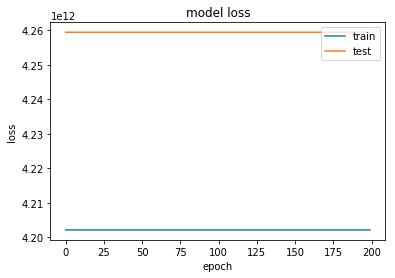

In [12]:
# importing visualization tools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

autoencoder = load_model('../saved/basicAE.h5')

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

In [13]:
import numpy as np

predictions = autoencoder.predict(X_test)
# calculate my own MSE
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': y_test})
error_df.describe()

,reconstruction_error,true_class
count,1.272524e+06,1.272524e+06
mean,4.273575e+12,1.273060e-03
std,7.157309e+13,3.565727e-02
min,1.149011e+01,0.000000e+00
25%,3.821797e+08,0.000000e+00
50%,2.526156e+10,0.000000e+00
75%,5.597479e+11,0.000000e+00
max,2.300391e+16,1.000000e+00


In [15]:
predictions[0:10]
y_test.head(10)

3737323    0
264914     0
85647      0
5899326    0
2544263    0
3494160    0
2331654    0
1414955    0
2938135    0
6133806    0
Name: isFraud, dtype: int64